# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [15]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [16]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [17]:
#from sklearn.model_selection import train_test_split
num_features_total = 1000
num_features_best = 100

N = 100
#N = 10000
# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)


#X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
# Simple classification model
#model = LinearSVC()

#model.fit(X_train , y_train)
#predict =model.predict(X_test)
#print (accuracy_score(y_test, predict))

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
#cv_score = cross_val_score(model, X, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.99


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

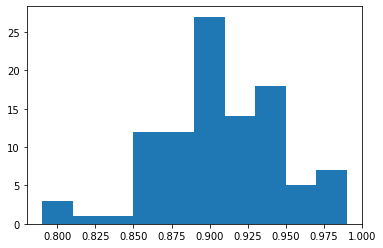

In [18]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
  #return cross_val_score(model, X, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

## Task 1 (3 points)

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

Answer : The Problem is that we are doing feature selection which means that we are getting rid of the features that are loosly correlated with the data and taking the best features (even if the features are generated randomly but we are taking the best random features there is).

below we are trying to see how not taking feature selection is going to affect the accuracy

In [19]:
#from sklearn.model_selection import train_test_split
num_features_total = 1000
num_features_best = 100

N = 100
#N = 10000
# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
#X_best = FeatureSelector(num_features_best).fit_transform(X, y)


#X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
# Simple classification model
model = LinearSVC()

#model.fit(X_train , y_train)
#predict =model.predict(X_test)
#print (accuracy_score(y_test, predict))

# Estimatin accuracy using cross-validation:
#cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
cv_score = cross_val_score(model, X, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.48


on the other hand : the Cv score does not reach the value of 0.5 exactly becuase of: First the small number of the data as input (N = 100) and Second the Cross-Validation step on the data, Third the number target input from class (0) dosen't match number of target input from the other class (1)

In [20]:
print (len([t  for t in y  if t ==0 ]))

46


## Task 2 (3 points)

Let's come back to Task 3 of Data Handling HW.
Build a model with KNeighborsClassifier to get a higher accuracy on 5-fold Cross Validation than you achieve using your previosly fitted model (you can just copy the params from the previous notebook). 

Use `sklearn.model_selection.GridSearchCV` to find best parameters.  You may check the parameters'  description as follows:
``` python
help(KNeighborsClassifier)
``` 

In [21]:
!wget https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv

--2022-12-24 07:13:44--  https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  58.89K  --.-KB/s    in 0.001s  

2022-12-24 07:13:44 (53.4 MB/s) - ‘train.csv’ saved [60302/60302]



In [22]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

data = pd.read_csv("train.csv", index_col='PassengerId')

In [23]:
def feature_selection_and_preprocessing(dataset):
  #getting rid of tickets and cabins numbers
  data = dataset.drop(['Ticket','Cabin'],axis =1)
  
  # droping names 
  data = data.drop(['Name'], axis=1)

  # convert sex from catigorical to numerical
  data['Sex'] = data['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
  

  #messuring the family for each passenger and creating a new feature which is IsAlone 

  data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
  data['IsAlone'] = 0
  data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1
  data = data.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)

  #fill embarked missing values and convert to numerical
  freq_port = data.Embarked.dropna().mode()[0]
  data['Embarked'] = data['Embarked'].fillna(freq_port)
  data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

  # convert fare into ranges  
  # note that we can get those rages by using pd.qcut(data['Fare'], 4)

  data['Fare'].fillna(data['Fare'].dropna().median(), inplace=True)
  data.loc[ data['Fare'] <= 7.91, 'Fare'] = 0
  data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare'] = 1
  data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare']   = 2
  data.loc[ data['Fare'] > 31, 'Fare'] = 3
  data['Fare'] = data['Fare'].astype(int)


  #fill na in Age with mean
  mean_value=data['Age'].mean()
  data['Age'] = data['Age'].fillna(mean_value)

  #replace age based on bands into 5 catigories we can aquire those bands by running pd.qcut(data['Age'], 5)
  data.loc[ data['Age'] <= 16, 'Age'] = 0
  data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age'] = 1
  data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age'] = 2
  data.loc[(data['Age'] > 48) & (data['Age'] <= 64), 'Age'] = 3
  data.loc[ data['Age'] > 64, 'Age'] = 4

  data['Age'] = data['Age'].astype(int)

  return data

In [24]:
data_train = data.iloc[:-100]
data_test = data.iloc[-100:]

In [25]:
base_model = KNeighborsClassifier()

k_range = list(range(1, 10))
param_grid = dict(n_neighbors=k_range)

gscv = GridSearchCV(base_model, param_grid, scoring='accuracy', cv=5, n_jobs=-1)

X = feature_selection_and_preprocessing(
        data_test.drop('Survived', axis=1)
    )
y = data_test['Survived']
gscv.fit(X, y)
print(gscv.best_params_)

{'n_neighbors': 3}


In [26]:
model = KNeighborsClassifier(
    n_neighbors=gscv.best_params_['n_neighbors']
)

In [27]:
model.fit(
    feature_selection_and_preprocessing(
        data_train.drop('Survived', axis=1)
    ),
    data_train['Survived']
)


KNeighborsClassifier(n_neighbors=3)

In [28]:
test_predictions = model.predict(
    feature_selection_and_preprocessing(
        data_test.drop('Survived', axis=1)
    )
)

In [29]:
print("Test accuracy:", accuracy_score(
    data_test['Survived'],
    test_predictions
))

Test accuracy: 0.85


as we could see theGridSearch yielded the same results for the parmeter 'n-neighbors' that we used in the previous HW hence the same accuracy was produced